# Outdoor Case Study
author: Mountain Liu
Last Modified: 2023-08-03

## Overview

You work for a consulting company on an island called Gotland, with a population of 2,000. The consulting company has access to Gotland’s sole bank’s transactional data which is de-identified and privacy compliant. 

The CEO of Outdoor has approached you to provide consulting advice. She is worried about slowing growth at Outdoor and wants to understand the performance of Outdoor versus its key competitors Camping Land, River Deep Camping and The Camping Hut. In addition to this, the CEO would like you to provide three insights from the data and corresponding ideas on how Outdoor could take each insight and apply it to lift sales growth. 

An example of an insight a client may expect is: 
- Revenue is significantly higher in the summer over the holiday period. To increase sales throughout the year, Outdoor could design a marketing campaign encouraging people to buy fishing supplies on an upcoming public holiday 

The CEO has asked you to preferably prepare a one slide dashboard and highlight three key insights. Also include any scripts/techniques used to slice the data. 

Additional notes: 
- Bank rules state that insights cannot be deduced from singular customers and that data and metrics presented must be aggregated to either a minimum of region, age band or gender (or a combination of two of these) 
- Bank rules state that when providing the performance metrics of competitor companies you cannot display individual competitor metrics, they must be presented as aggregations of at least three competitor brands


## Data Preprocessing

In [297]:
# import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# set the style of seaborn
sns.set(style="whitegrid")

In [298]:
# Read the Excel file
xls = pd.ExcelFile("/Users/liuqi/PycharmProjects/CaseStudy/Outdoor Case Study Data.xlsx")

# Get the names of the sheets in the file
sheet_names = xls.sheet_names
sheet_names

['Customers', 'Transactions', 'Stores']

In [299]:
# Customers data
df_customers = pd.read_excel(xls, 'Customers')

# Transactions data
df_transactions = pd.read_excel(xls, 'Transactions')

# Stores data
df_stores = pd.read_excel(xls, 'Stores')

In [300]:
df_customers.head()

,CustomerID,Region,Age Band,Gender
0,10001,3,50-60,male
1,10002,2,30-40,female
2,10003,3,50-60,female
3,10004,4,20-30,male
4,10005,1,40-50,male


In [301]:
df_transactions.head()

,TransactionID,CustomerID,Year,Amount,StoreID,Weekday / Weekend
0,10001,10463,2012,48.45,10003,Weekend
1,10001,10463,2012,68.60,10004,Weekend
2,10001,11869,2012,35.75,10001,Weekend
3,10002,11869,2012,47.55,10003,Weekday
4,10003,11869,2012,53.45,10003,Weekday


In [302]:
df_stores.head()

,StoreID,Brand,Region
0,10001,Camping Land,1
1,10002,Outdoor,1
2,10003,River Deep Camping,1
3,10004,The Camping Hut,1
4,20001,Camping Land,2


In [303]:
# Merge transactions with stores to get brand information for each transaction
df_trans_stores = pd.merge(df_transactions, df_stores, on='StoreID')

# Then merge the result with customers data to get customer information for each transaction
df_all = pd.merge(df_trans_stores, df_customers, on='CustomerID')

# In the merged dataframe, 'Region_x' refers to the region of the transaction, 
# while 'Region_y' refers to the region of the store where the transaction took place.
# To make this clearer, let's rename these columns.

df_all = df_all.rename(columns={'Region_x': 'Transaction Region', 'Region_y': 'Store Region'})


In [304]:
# save the merged dataframe to a csv file
df_all.to_csv('df_all.csv', index=False)

## Data Analysis
For the sake of completeness, we have divided our analysis of Outdoor into **Market Analysis** and **Competitor Analysis**.

### Outdoor Market Analysis

* 1\. Overall Market Performance
    * 1.1\. Analyze the overall performance of the Outdoor market, including total sales, sales growth rate, market share, and more.
    <br><br>
* 2\. Segmented Market Performance
    * 2.1\. **Regional Segmentation**: Analyze Outdoor's sales performance in different regions. This will reveal which regions have the highest sales and which regions show the fastest sales growth.
    <br><br>
    * 2.2\. **Time Segmentation**: Analyze Outdoor's sales data to determine if there are significant temporal patterns. For example, whether sales are significantly higher on weekends compared to weekdays.
    <br><br>
    * 2.3\. **Customer Segmentation**: Segment customers based on age and gender, and analyze the sales performance of each segmented market. This may uncover markets with growth potential.


#### 1. Overall Market Performance

##### 1.1
Analyze the overall performance of the Outdoor market, including total sales, sales growth rate, market share, and more.

In [305]:
# Calculate total sales for each brand
df_brand_total_sales = df_all.groupby('Brand')['Amount'].sum().reset_index(name='Total Sales')

# Calculate total sales for Outdoor
outdoor_total_sales = df_brand_total_sales[df_brand_total_sales['Brand'] == 'Outdoor']['Total Sales'].values[0]

# Calculate sales growth rate for Outdoor
df_outdoor_sales_year = df_all[df_all['Brand'] == 'Outdoor'].groupby('Year')['Amount'].sum().reset_index(name='Sales')
outdoor_sales_growth_rate = df_outdoor_sales_year.pct_change()['Sales'].values[1]

# Calculate market share for Outdoor
total_sales = df_brand_total_sales['Total Sales'].sum()
outdoor_market_share = outdoor_total_sales / total_sales

outdoor_total_sales, outdoor_sales_growth_rate, outdoor_market_share

(106474.5, -0.018817369364139358, 0.26691111385745836)

In [306]:
df_outdoor_sales_year

,Year,Sales
0,2012,53742.9
1,2013,52731.6


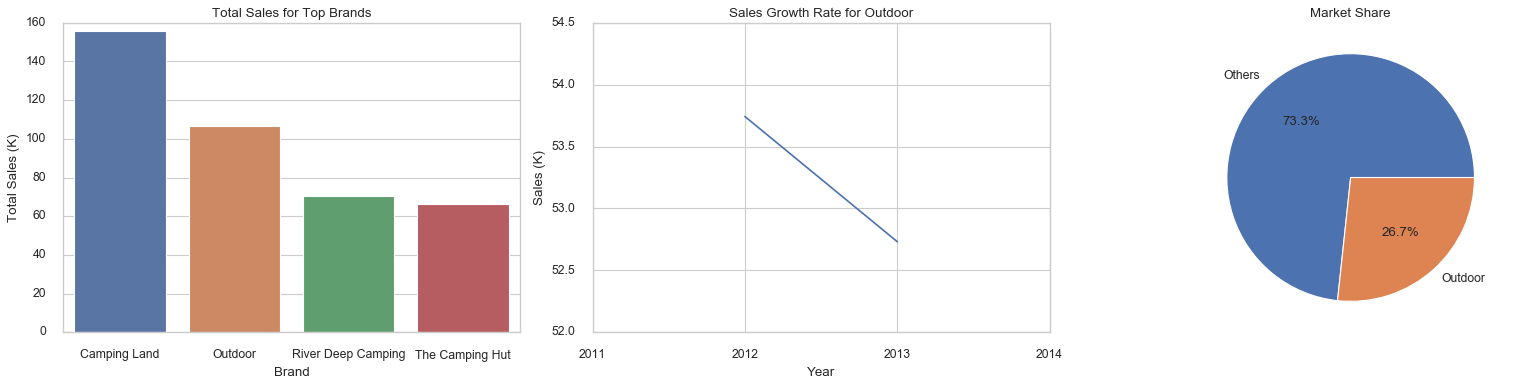

In [307]:
# Convert amount to amount in K
df_brand_total_sales['Total Sales (K)'] = df_brand_total_sales['Total Sales'] / 1000
df_outdoor_sales_year['Sales (K)'] = df_outdoor_sales_year['Sales'] / 1000

# Sort brands by total sales
df_brand_total_sales_sorted = df_brand_total_sales.sort_values(by='Total Sales (K)', ascending=False)

# Select top 5 brands for bar plot
top_brands = df_brand_total_sales_sorted['Brand'].tolist()[:5]
df_top_brands = df_brand_total_sales_sorted[df_brand_total_sales_sorted['Brand'].isin(top_brands)]

# Prepare data for pie chart
df_brand_market_share = df_brand_total_sales.copy()
df_brand_market_share.loc[~df_brand_market_share['Brand'].isin(['Outdoor']), 'Brand'] = 'Others'
df_brand_market_share = df_brand_market_share.groupby('Brand')['Total Sales (K)'].sum().reset_index()

plt.figure(figsize=(20, 5))

# Bar plot for total sales of top brands
plt.subplot(1, 3, 1)
sns.barplot(x='Brand', y='Total Sales (K)', data=df_top_brands)
plt.title('Total Sales for Top Brands')

# Line plot for sales growth rate
plt.subplot(1, 3, 2)
sns.lineplot(x='Year', y='Sales (K)', data=df_outdoor_sales_year)
years = list(range(2011, 2015))
plt.xticks(years, [str(year) for year in years])
plt.yticks(np.arange(52, 55, 0.5))

plt.title('Sales Growth Rate for Outdoor')

# Pie chart for market share
plt.subplot(1, 3, 3)
plt.pie(df_brand_market_share['Total Sales (K)'], labels=df_brand_market_share['Brand'], autopct='%1.1f%%')
plt.title('Market Share')

plt.tight_layout()
plt.show()


#### 2. Segmented Market Performance

##### 2.1. Regional Segmentation
Analyze Outdoor's sales performance in different regions. This will reveal which regions have the highest sales and which regions show the fastest sales growth.

In [308]:
df_outdoor = df_all[df_all['Brand'] == 'Outdoor']

# Group by the transaction region and year, calculate the sum of amount
df_outdoor_region_year = df_outdoor.groupby(['Transaction Region', 'Year'])['Amount'].sum().reset_index()

# convert the 'Amount' to thousands and round to one decimal place, which will be used in the plot easily
df_outdoor_region_year['Amount (K)'] = round(df_outdoor_region_year['Amount'] / 1000, 1)

df_outdoor_region_year

,Transaction Region,Year,Amount,Amount (K)
0,1,2012,14938.25,14.9
1,1,2013,14504.50,14.5
2,3,2012,20685.30,20.7
3,3,2013,20032.45,20.0
4,4,2012,18119.35,18.1
5,4,2013,18194.65,18.2


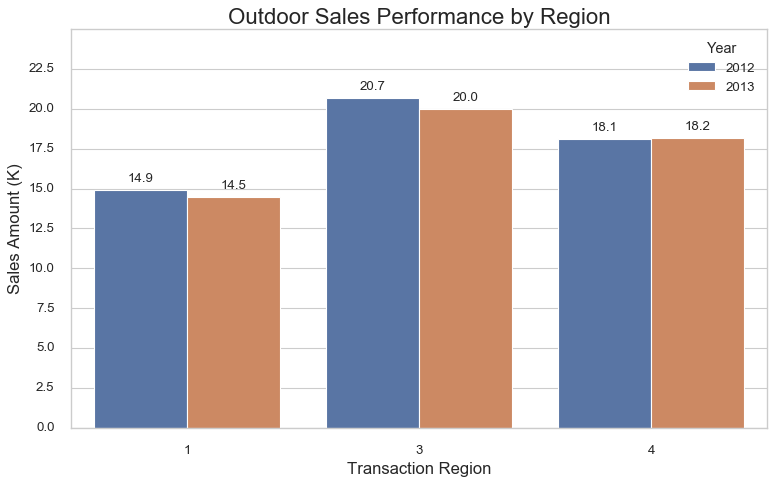

In [309]:
# Plot the bar chart to show the sales performance by region and year
plt.figure(figsize=(10, 6))
sns.barplot(x="Transaction Region", y="Amount (K)", hue="Year", data=df_outdoor_region_year, errorbar=None)

# Add data labels
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():.1f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=12)

plt.title('Outdoor Sales Performance by Region', fontsize=20)
plt.xlabel('Transaction Region', fontsize=15)
plt.ylabel('Sales Amount (K)', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(np.arange(0, 25, 2.5), fontsize=12)
plt.legend(title='Year', title_fontsize='13', loc='upper right', fontsize='12')
plt.show()


In [310]:
# Calculate the sales growth rate for each region from 2012 to 2013
# Calculate the sales growth rate for each region
df_outdoor_region_year = df_outdoor_region_year.sort_values(['Transaction Region', 'Year'])
df_outdoor_region_year['Sales Growth Rate'] = df_outdoor_region_year.groupby('Transaction Region')[
                                                  'Amount'].pct_change() * 100

# Pivot the table to display the sales growth rate from 2012 to 2013 for each region
df_growth_rate = df_outdoor_region_year.pivot(index='Transaction Region', columns='Year', values='Sales Growth Rate')

# Keep only the growth rate from 2012 to 2013
df_growth_rate = df_growth_rate[[2013]]

# Change the format to percentage
df_growth_rate = df_growth_rate.applymap(lambda x: f'{x:.2f}%' if pd.notnull(x) else '')

df_growth_rate.rename(columns={2013: 'Sales Growth Rate (2012-2013)'}, inplace=True)

df_growth_rate

Year,Sales Growth Rate (2012-2013)
Transaction Region,
1,-2.90%
3,-3.16%
4,0.42%


Through the analysis of Outdoor's regional sales performance, we can observe the following:

1. Regardless of the year (2012 or 2013), Region 3 consistently achieved the highest sales, while Region 1 had the lowest sales.
2. During this period, Region 4 experienced a sales growth of 0.42%, while Region 1 and Region 3 witnessed a sales decline of 2.90% and 3.16%, respectively.

These findings may provide valuable guidance for Outdoor's strategies:

1. Since Region 3 consistently generates the highest sales, Outdoor can consider increasing advertising investments in this region to further boost sales.
2. As Region 4 shows the fastest sales growth, Outdoor can contemplate increasing advertising investments in this region to capitalize on its potential for further sales growth.

##### 2.2. Time Segmentation
Analyze Outdoor's sales data to determine if there are significant temporal patterns. For example, whether sales are significantly higher on weekends compared to weekdays.

In [311]:
# Group by 'Weekday / Weekend' and 'Year', calculate the sum of amount
df_outdoor_weekday_year = df_outdoor.groupby(['Weekday / Weekend', 'Year'])['Amount'].sum().reset_index()

# Convert the 'Amount' to thousands and round to one decimal place
df_outdoor_weekday_year['Amount (K)'] = round(df_outdoor_weekday_year['Amount'] / 1000, 1)

df_outdoor_weekday_year


,Weekday / Weekend,Year,Amount,Amount (K)
0,Weekday,2012,34557.5,34.6
1,Weekday,2013,33868.8,33.9
2,Weekend,2012,19185.4,19.2
3,Weekend,2013,18862.8,18.9


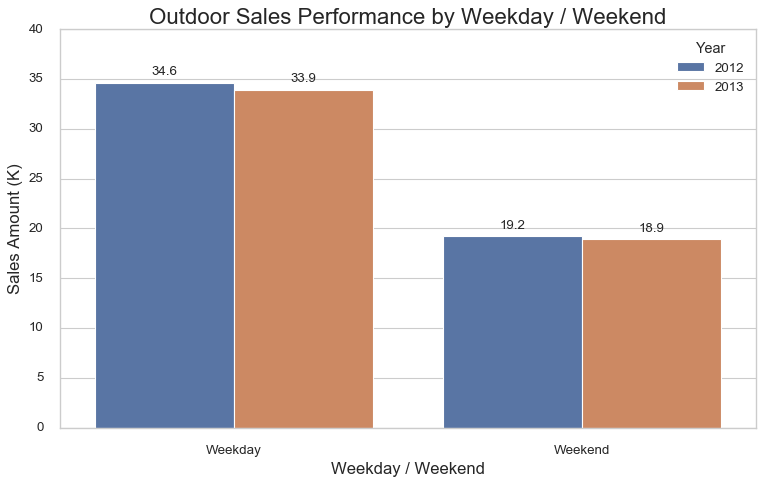

In [312]:
# Plot the bar chart to show the sales performance by weekday / weekend and year
plt.figure(figsize=(10, 6))
sns.barplot(x="Weekday / Weekend", y="Amount (K)", hue="Year", data=df_outdoor_weekday_year, errorbar=None)

# Add data labels
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():.1f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Outdoor Sales Performance by Weekday / Weekend', fontsize=20)
plt.xlabel('Weekday / Weekend', fontsize=15)
plt.ylabel('Sales Amount (K)', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(np.arange(0, 41, 5), fontsize=12)
plt.legend(title='Year', title_fontsize='13', loc='upper right', fontsize='12')
plt.show()

Through the analysis of Outdoor's seasonal sales, we have observed the following:

1. Whether in 2012 or 2013, sales on weekends were higher than on weekdays. However, when considering sales on an annual basis, the difference between weekdays and weekends is not significant. This observation suggests that weekdays and weekends may not have a significant impact on Outdoor's sales performance, which could be related to Outdoor's business model or product attributes.


##### 2.3. Customer Segmentation
Segment customers based on age and gender, and analyze the sales performance of each segmented market. This may uncover markets with growth potential.

In [313]:
# Group by 'Age Band', 'Gender' and 'Year', calculate the sum of amount
df_outdoor_age_gender_year = df_outdoor.groupby(['Age Band', 'Gender', 'Year'])['Amount'].sum().reset_index()

# Convert the 'Amount' to thousands and round to one decimal place
df_outdoor_age_gender_year['Amount (K)'] = round(df_outdoor_age_gender_year['Amount'] / 1000, 1)

df_outdoor_age_gender_year


,Age Band,Gender,Year,Amount,Amount (K)
0,20-30,female,2012,5331.75,5.3
1,20-30,female,2013,5757.85,5.8
2,20-30,male,2012,4899.55,4.9
3,20-30,male,2013,4900.55,4.9
4,30-40,female,2012,6805.90,6.8
5,30-40,female,2013,6300.25,6.3
6,30-40,male,2012,5271.00,5.3
7,30-40,male,2013,5316.75,5.3
8,40-50,female,2012,13046.80,13.0
9,40-50,female,2013,12274.05,12.3


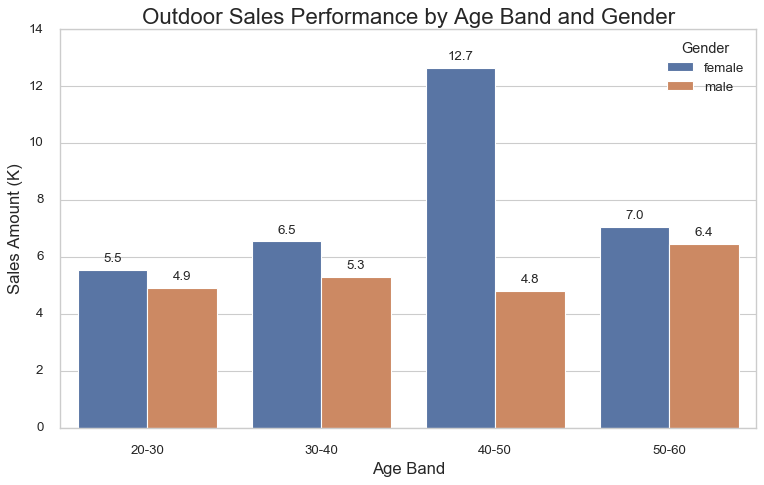

In [314]:
# Plot the bar chart to show the sales performance by age band and gender
plt.figure(figsize=(10, 6))
sns.barplot(x="Age Band", y="Amount (K)", hue="Gender", data=df_outdoor_age_gender_year, errorbar=None)

# Add data labels
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():.1f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Outdoor Sales Performance by Age Band and Gender', fontsize=20)
plt.xlabel('Age Band', fontsize=15)
plt.ylabel('Sales Amount (K)', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Gender', title_fontsize='13', loc='upper right', fontsize='12')
plt.show()

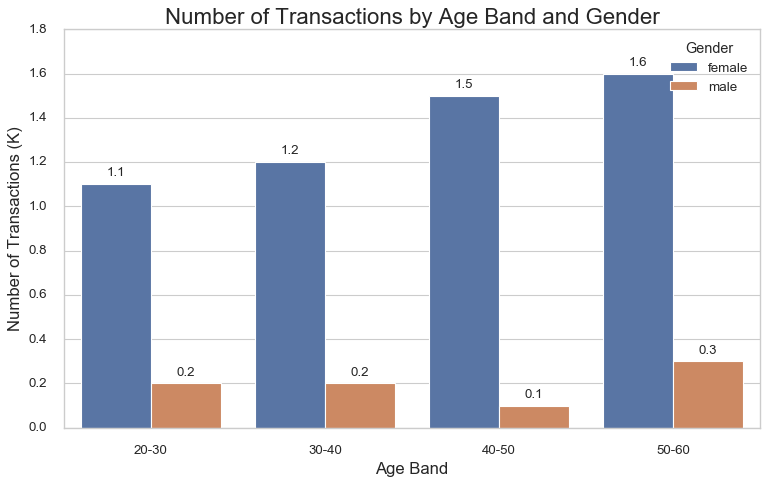

In [315]:
# Calculate the number of transactions for each age band and gender
df_outdoor_age_gender_transactions = df_outdoor.groupby(['Age Band', 'Gender']).size().reset_index(name='Transactions')

# Convert the 'Transactions' to thousands and round to one decimal place
df_outdoor_age_gender_transactions['Transactions (K)'] = round(
    df_outdoor_age_gender_transactions['Transactions'] / 1000, 1)

# Plot the data
plt.figure(figsize=(10, 6))
sns.barplot(x="Age Band", y="Transactions (K)", hue="Gender", data=df_outdoor_age_gender_transactions, errorbar=None)

# Add data labels
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():.1f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Number of Transactions by Age Band and Gender', fontsize=20)
plt.xlabel('Age Band', fontsize=15)
plt.ylabel('Number of Transactions (K)', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(np.arange(0, 2, 0.2), fontsize=12)
plt.legend(title='Gender', title_fontsize='13', loc='upper right', fontsize='12')
plt.show()


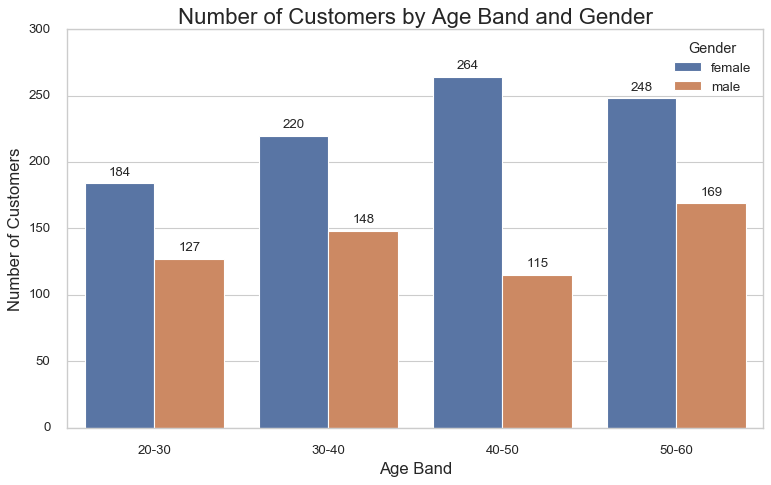

In [316]:
# Calculate the number of unique customers for each age band and gender without converting to K units
df_outdoor_age_gender_customers = df_outdoor.groupby(['Age Band', 'Gender'])['CustomerID'].nunique().reset_index(
    name='Customers')

# Plot the data
plt.figure(figsize=(10, 6))
sns.barplot(x="Age Band", y="Customers", hue="Gender", data=df_outdoor_age_gender_customers, errorbar=None)

# Add data labels
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Number of Customers by Age Band and Gender', fontsize=20)
plt.xlabel('Age Band', fontsize=15)
plt.ylabel('Number of Customers', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Gender', title_fontsize='13', loc='upper right', fontsize='12')
plt.show()


Through the analysis of Outdoor's customer segmentation, we have made the following observations:

1. Across all age groups, the sales performance of female customers surpasses that of male customers. This trend is likely influenced by the attributes of Outdoor's products.

2. Outdoor's primary target audience appears to be women aged between 40 and 50 years. This specific age group shows the highest sales revenue, transaction frequency, and customer count. This preference is possibly due to the product attributes catered towards this demographic.

3. For other age groups of female customers, there is no significant variance in the sales performance of Outdoor's products. This suggests that the product attributes may not have a substantial impact on these age groups of female customers.


在对 Outdoor 单一品牌进行玩市场整体表现和细分市场表现的分析后，我们需要进行品牌间的对比分析，以便找出潜在的增长机会。这里我们将使用 Camping Land、Outdoor、River Deep Camping、The Camping Hut 这四个品牌进行对比分析，因为他们的市场表现都相当强劲，在市场份额的排名中，位于排名的最前端。

### Competitor Analysis

* 1\. Overall Market Comparison
    * 1.1\. Compare total sales and sales growth rate to determine Outdoor's performance against competitors.
    <br><br>
* 2\. Segmented Market Comparison
    * 2.1\. **Regional Segmentation**: Compare sales performance of different brands across regional segments to provide Outdoor with key insights and strategic recommendations.
    <br><br>
    * 2.2\. **Customer Segmentation**: Compare the sales performance of different brands within customer segments to provide Outdoor with key insights and strategic recommendations.


In [317]:
# Selecting the brands for comparison analysis
selected_brands = ["Camping Land", "Outdoor", "River Deep Camping", "The Camping Hut"]

# Correcting the column name and filtering the data for the selected brands
df_competitors_analysis = df_all[df_all['Brand'].isin(selected_brands)]

# Checking for missing values and data types
df_competitors_analysis.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 22978 entries, 0 to 22977
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   TransactionID       22978 non-null  int64  
 1   CustomerID          22978 non-null  int64  
 2   Year                22978 non-null  int64  
 3   Amount              22978 non-null  float64
 4   StoreID             22978 non-null  int64  
 5   Weekday / Weekend   22978 non-null  object 
 6   Brand               22978 non-null  object 
 7   Transaction Region  22978 non-null  int64  
 8   Store Region        22978 non-null  int64  
 9   Age Band            22978 non-null  object 
 10  Gender              22978 non-null  object 
dtypes: float64(1), int64(6), object(4)
memory usage: 2.1+ MB


#### 1. Overall Market Performance

##### 1.1
Compare total sales and sales growth rate to determine Outdoor's performance against competitors.


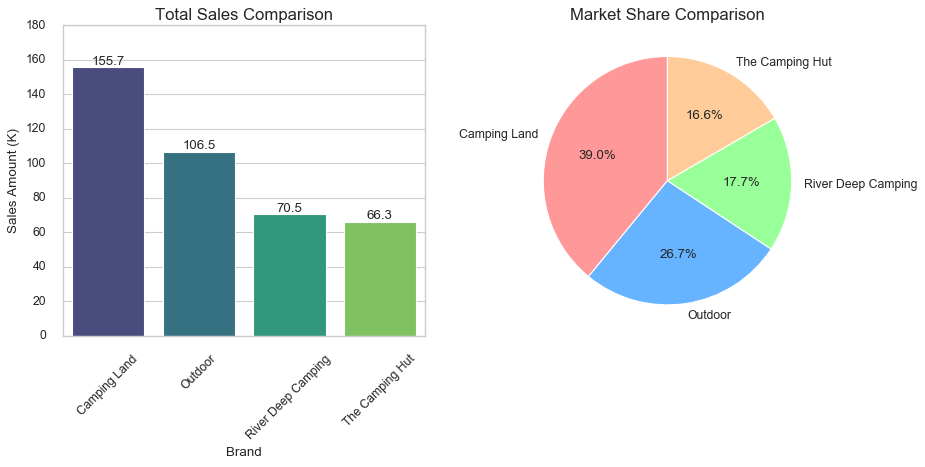

In [318]:
# Calculating the total sales for each brand
total_sales_per_brand = df_competitors_analysis.groupby('Brand')['Amount'].sum().reset_index()

# Sorting the brands based on total sales
total_sales_per_brand = total_sales_per_brand.sort_values(by='Amount', ascending=False)

# Converting the sales amount to thousands for better readability
total_sales_per_brand['Amount (K)'] = total_sales_per_brand['Amount'] / 1000

# Plotting the total sales in thousands
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='Brand', y='Amount (K)', data=total_sales_per_brand, palette='viridis')
# Adding the amount on top of each bar
for i, amount in enumerate(total_sales_per_brand['Amount (K)']):
    plt.text(i, amount, f'{amount:.1f}', ha='center', va='bottom', fontsize=12)
plt.title('Total Sales Comparison', fontsize=15)
plt.xlabel('Brand', fontsize=12)
plt.ylabel('Sales Amount (K)', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(np.arange(0, 181, 20))

# Calculating the market share for each brand
total_sales_per_brand['Market Share'] = total_sales_per_brand['Amount'] / total_sales_per_brand['Amount'].sum() * 100

# Plotting the market share using pie chart
plt.subplot(1, 2, 2)
plt.pie(total_sales_per_brand['Market Share'], labels=total_sales_per_brand['Brand'], autopct='%1.1f%%',
        colors=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'], startangle=90)
plt.title('Market Share Comparison', fontsize=15)

plt.tight_layout()
plt.show()



As seen in the chart above, Outdoor's market sales are slightly lower than Camping Land, but higher than River Deep Camping and The Camping Hut.

In [319]:
# Calculating the sales for each brand per year
df_competitors_sales_year = df_competitors_analysis.groupby(['Brand', 'Year'])['Amount'].sum().reset_index()

# Calculating the yearly sales growth rate
df_competitors_sales_year['Sales Growth Rate'] = df_competitors_sales_year.groupby('Brand')['Amount'].pct_change() * 100

df_competitors_sales_year

,Brand,Year,Amount,Sales Growth Rate
0,Camping Land,2012,89331.65,NaN
1,Camping Land,2013,66367.75,-25.706343
2,Outdoor,2012,53742.90,NaN
3,Outdoor,2013,52731.60,-1.881737
4,River Deep Camping,2012,40210.35,NaN
5,River Deep Camping,2013,30267.95,-24.725972
6,The Camping Hut,2012,36321.30,NaN
7,The Camping Hut,2013,29940.20,-17.568479


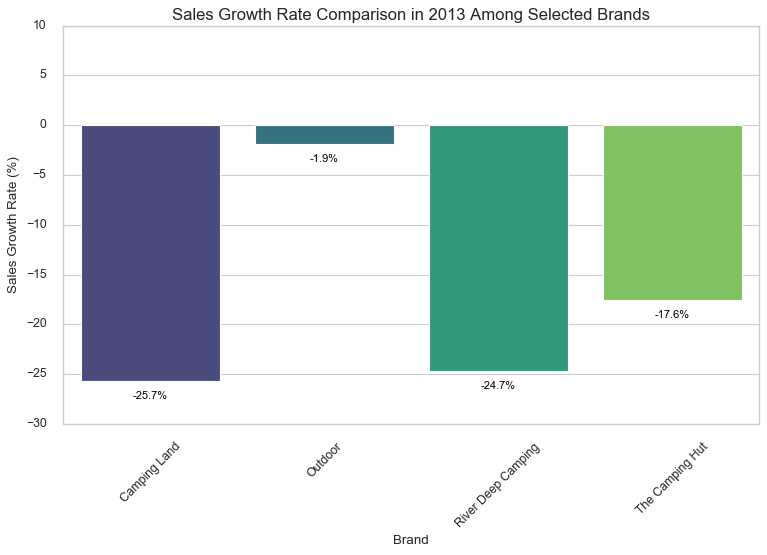

In [320]:
# Removing the data for year 2012 as we are only interested in the growth rate from 2012 to 2013
df_competitors_sales_growth_2013 = df_competitors_sales_year[df_competitors_sales_year['Year'] == 2013]

# Plotting the sales growth rate for 2013 using a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Brand', y='Sales Growth Rate', data=df_competitors_sales_growth_2013, palette='viridis')

# Adding the growth rate below each bar
for i, rate in enumerate(df_competitors_sales_growth_2013['Sales Growth Rate']):
    plt.text(i, rate - 2, f'{rate:.1f}%', ha='center', va='bottom', fontsize=10, color='black')

plt.title('Sales Growth Rate Comparison in 2013 Among Selected Brands', fontsize=15)
plt.xlabel('Brand', fontsize=12)
plt.ylabel('Sales Growth Rate (%)', fontsize=12)
plt.xticks(rotation=45)
plt.ylim(-30, 10)  # Adjusting y-axis range
plt.show()


All brands have a negative sales growth rate, which means that all brands are experiencing a decline in sales.

1. Outdoor had the smallest decrease in sales growth rate, which means that Outdoor had the smallest decrease in sales compared to the other brands

2. the remaining three brands had a significant drop in sales, with Camping Land having the largest drop in sales growth rate.

#### 2. Segmented Market Comparison

##### 2.1. Regional Segmentation
Compare sales performance of different brands across regional segments to provide Outdoor with key insights and strategic recommendations.

In [321]:
# Grouping the sales amount by brand, region, and year
df_competitors_region_year = \
    df_all[df_all['Brand'].isin(selected_brands)].groupby(['Brand', 'Transaction Region', 'Year'])[
        'Amount'].sum().reset_index()

# Calculating the sales growth rate
df_competitors_region_year = df_competitors_region_year.sort_values(['Brand', 'Transaction Region', 'Year'])
df_competitors_region_year['Sales Growth Rate'] = df_competitors_region_year.groupby(['Brand', 'Transaction Region'])[
                                                      'Amount'].pct_change() * 100

df_competitors_region_year


,Brand,Transaction Region,Year,Amount,Sales Growth Rate
0,Camping Land,1,2012,17968.50,NaN
1,Camping Land,1,2013,12473.85,-30.579347
2,Camping Land,2,2012,28707.25,NaN
3,Camping Land,2,2013,23845.20,-16.936662
4,Camping Land,3,2012,22556.70,NaN
5,Camping Land,3,2013,16060.00,-28.801642
6,Camping Land,4,2012,20099.20,NaN
7,Camping Land,4,2013,13988.70,-30.401708
8,Outdoor,1,2012,14938.25,NaN
9,Outdoor,1,2013,14504.50,-2.903620


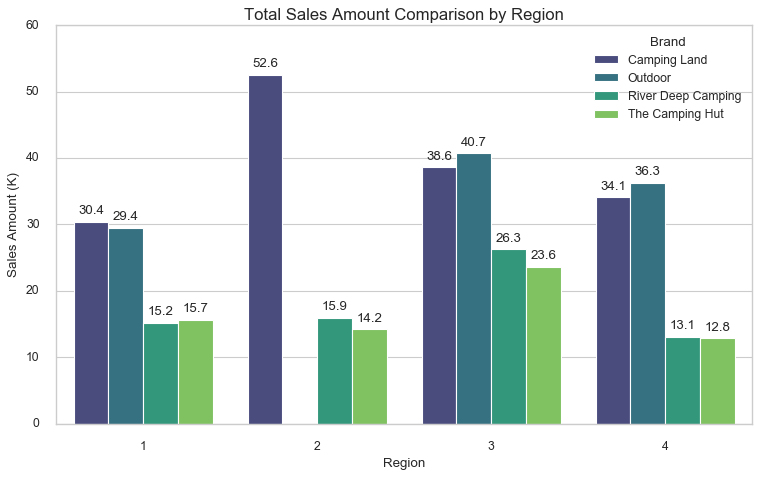

In [322]:
# Grouping the total sales amount by brand and region
df_competitors_region_total = df_all[df_all['Brand'].isin(selected_brands)].groupby(['Brand', 'Transaction Region'])[
    'Amount'].sum().reset_index()

# Convert the amount to unit K
df_competitors_region_total['Amount (K)'] = df_competitors_region_total['Amount'] / 1000

# Plotting the total sales amount by brand and region
plt.figure(figsize=(10, 6))
sns.barplot(x='Transaction Region', y='Amount (K)', hue='Brand', data=df_competitors_region_total, palette='viridis')
plt.title('Total Sales Amount Comparison by Region', fontsize=15)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Sales Amount (K)', fontsize=12)

# Add data labels
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():.1f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()


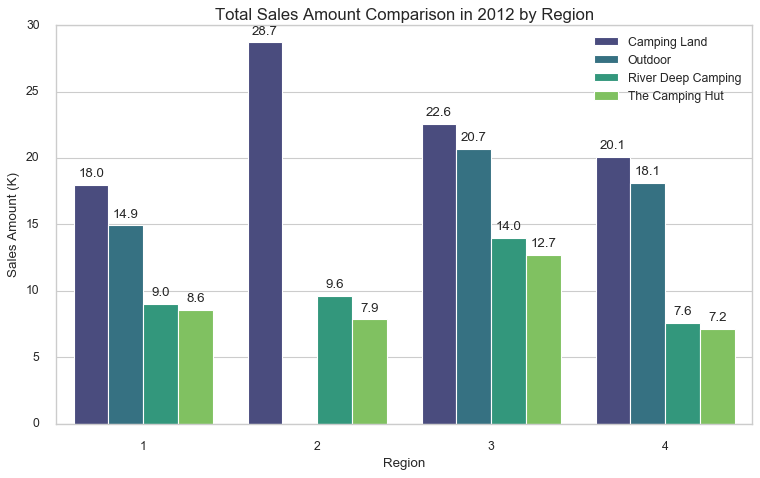

In [323]:
# Convert the amount to unit K
df_competitors_region_year['Amount (K)'] = df_competitors_region_year['Amount'] / 1000

# Plotting the total sales amount by brand and region in 2012
df_competitors_region_year_2012 = df_competitors_region_year[df_competitors_region_year['Year'] == 2012]

plt.figure(figsize=(10, 6))
sns.barplot(x='Transaction Region', y='Amount (K)', hue='Brand', data=df_competitors_region_year_2012,
            palette='viridis')
plt.yticks(np.arange(0, 31, 5))
plt.title('Total Sales Amount Comparison in 2012 by Region', fontsize=15)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Sales Amount (K)', fontsize=12)

# Add data labels
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():.1f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.legend(loc='upper right')

plt.show()

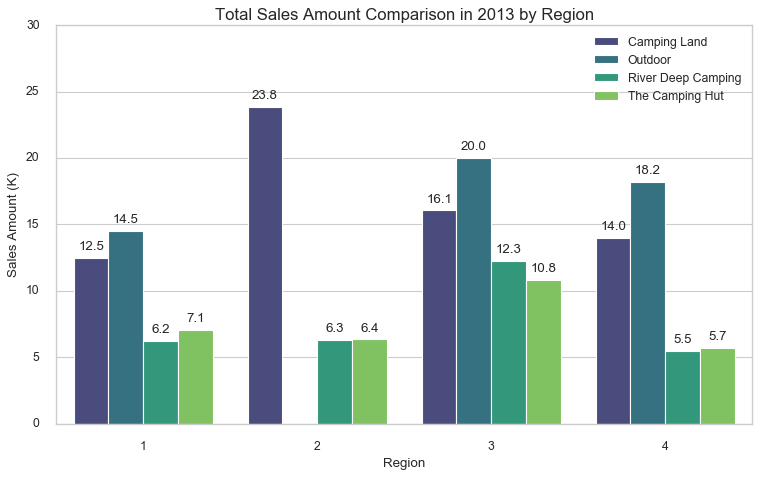

In [324]:
# Plotting the total sales amount by brand and region in 2013
df_competitors_region_year_2013 = df_competitors_region_year[df_competitors_region_year['Year'] == 2013]

plt.figure(figsize=(10, 6))
sns.barplot(x='Transaction Region', y='Amount (K)', hue='Brand', data=df_competitors_region_year_2013,
            palette='viridis')
plt.yticks(np.arange(0, 31, 5))
plt.title('Total Sales Amount Comparison in 2013 by Region', fontsize=15)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Sales Amount (K)', fontsize=12)

# Add data labels
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():.1f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.legend(loc='upper right')

plt.show()

The three graphs above display the sales figures for each brand in different regions, including the total sales and sales for the years 2012 and 2013. Based on the analysis, we have made the following observations:

1. Outdoor's sales in Region 2 are recorded as 0, indicating that Outdoor does not have any sales presence in Region 2 due to the absence of stores.

2. Comparing the total sales, Camping Land has the highest sales figures among the brands, and its sales in Region 2 are significantly higher than the other brands.

3. When comparing sales for the years 2012 and 2013, excluding the region where Outdoor has no stores (Region 2), we find that in 2012, Camping Land had the highest sales, slightly surpassing Outdoor. However, in 2013, Outdoor's sales were slightly higher than Camping Land's, which aligns with the findings from the sales growth rate analysis mentioned earlier.

4. River Deep Camping and The Camping Hut have considerable gaps in sales figures compared to the top two brands. However, the difference in sales between these two brands is not significant.



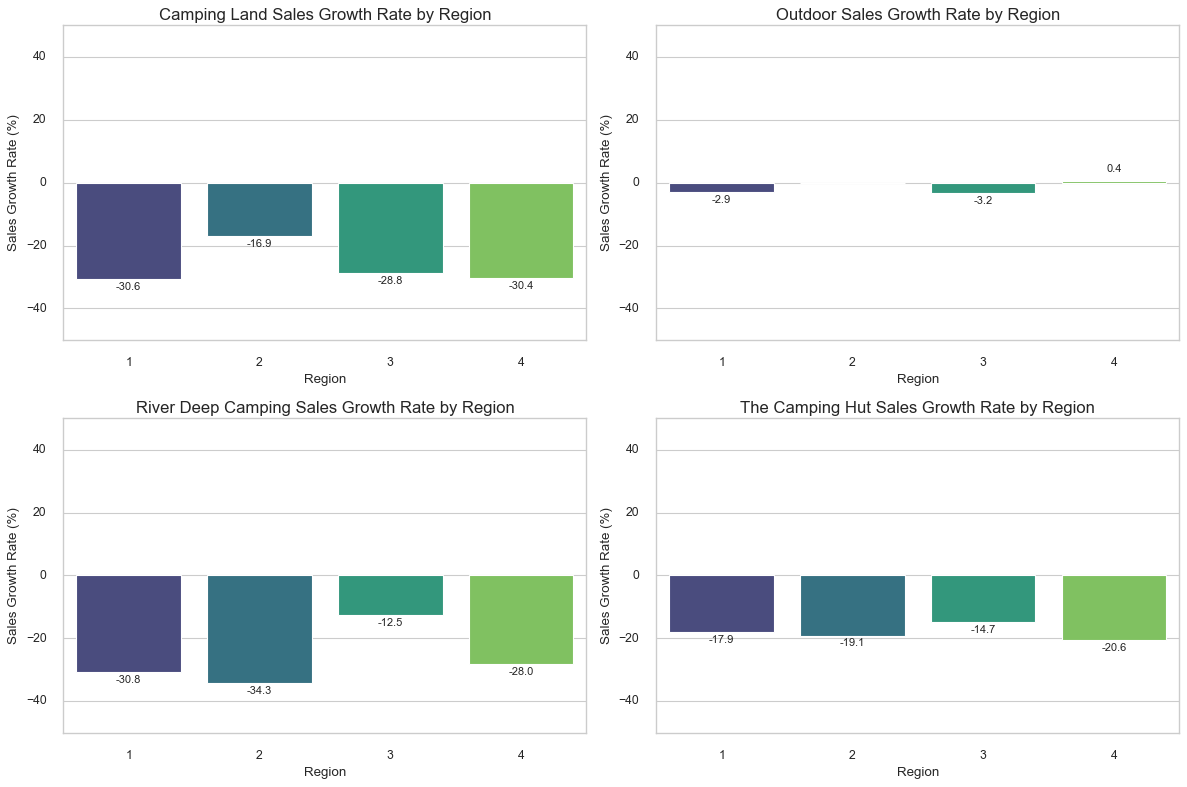

In [325]:
# Filter the sales growth rate data for 2013
df_competitors_region_year_2013 = df_competitors_region_year[df_competitors_region_year['Year'] == 2013]

# Creating subplots for each brand to show the sales growth rate by region in 2013
plt.figure(figsize=(15, 10))

for i, brand in enumerate(selected_brands, 1):
    plt.subplot(2, 2, i)
    df_brand_region_year_2013 = df_competitors_region_year_2013[df_competitors_region_year_2013['Brand'] == brand]

    # Check if all regions are present in the data, if not, add the missing region with 0 growth rate
    for region in range(1, 5):
        if region not in df_brand_region_year_2013['Transaction Region'].unique():
            new_row = {'Brand': brand, 'Transaction Region': region, 'Year': 2013, 'Sales Growth Rate': 0}
            df_brand_region_year_2013 = pd.concat([df_brand_region_year_2013, pd.DataFrame(new_row, index=[0])],
                                                  ignore_index=True)

    bar_plot = sns.barplot(x='Transaction Region', y='Sales Growth Rate', data=df_brand_region_year_2013,
                           palette='viridis')
    plt.title(f'{brand} Sales Growth Rate by Region', fontsize=15)
    plt.xlabel('Region', fontsize=12)
    plt.ylabel('Sales Growth Rate (%)', fontsize=12)
    plt.ylim(-50, 50)  # Adjusting y-axis range to make the plots consistent

    # Add data labels
    for p in bar_plot.patches:
        if p.get_height() > 0:  # Only add the label if the growth rate is positive
            bar_plot.annotate(format(p.get_height(), '.1f'),
                              (p.get_x() + p.get_width() / 2., p.get_height() + 0.5),
                              ha='center', va='center',
                              xytext=(0, 10), textcoords='offset points', fontsize=10)
        elif p.get_height() < 0:  # Only add the label if the growth rate is negative
            bar_plot.annotate(format(p.get_height(), '.1f'),
                              (p.get_x() + p.get_width() / 2., p.get_height() - 6),
                              ha='center', va='center',
                              xytext=(0, 10), textcoords='offset points', fontsize=10)

plt.tight_layout()
plt.show()


The above charts display the yearly sales growth rates of each brand in different regions. Based on the analysis, we have made the following observations:

1. Overall, there is a decline in the sales growth rates of all brands in all regions.

2. While Outdoor's sales growth rate has declined in Regions 1 and 3, it shows a slight increase in Region 4. However, we can still consider Outdoor's sales growth rate to be relatively stable across different regions.

3. The growth rate performance of other brands is significantly lower compared to Outdoor, and the decline in their sales growth rates is more pronounced in various regions.

Therefore, we believe:

1. The decline in sales for other brands in each region may provide a competitive advantage for Outdoor. This situation could be an opportunity to introduce new products or promotional activities to capture a larger market share while competitors are experiencing weaker performance.

2. Despite the overall decline in sales growth rates across different brands, Outdoor's relatively stable performance may indicate specific market dynamics or consumer preferences. A more comprehensive analysis of the market, including factors such as seasonality, age groups, and gender, could reveal deeper opportunities and challenges.



##### 2.1. Customer Segmentation
Compare the sales performance of different brands within customer segments to provide Outdoor with key insights and strategic recommendations.

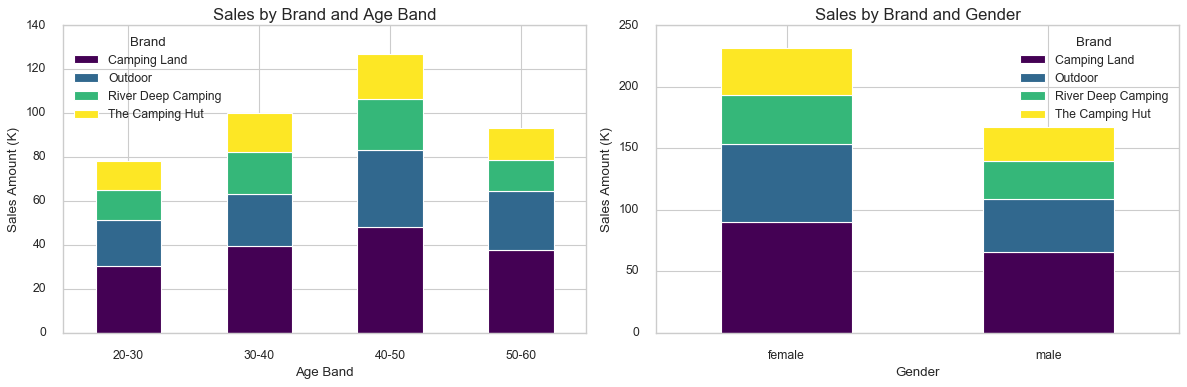

In [326]:
# Calculate sales by brand, age band and gender
df_competitors_age_gender = df_all.groupby(['Brand', 'Age Band', 'Gender'])['Amount'].sum().reset_index()

# Filter out the selected brands
df_competitors_age_gender = df_competitors_age_gender[df_competitors_age_gender['Brand'].isin(selected_brands)]

# Convert sales amount to unit K
df_competitors_age_gender['Amount (K)'] = df_competitors_age_gender['Amount'] / 1000

# Split the dataframe into two parts for better visualization
df_competitors_age = df_competitors_age_gender.groupby(['Brand', 'Age Band'])['Amount (K)'].sum().reset_index()
df_competitors_gender = df_competitors_age_gender.groupby(['Brand', 'Gender'])['Amount (K)'].sum().reset_index()

# Pivot the dataframes for stacked bar plots
df_competitors_age_pivot = df_competitors_age.pivot(index='Age Band', columns='Brand', values='Amount (K)').fillna(0)
df_competitors_gender_pivot = df_competitors_gender.pivot(index='Gender', columns='Brand', values='Amount (K)').fillna(0)

# Create subplots
plt.figure(figsize=(15, 5))

# Stacked bar plot for sales by brand and age band
plt.subplot(1, 2, 1)
df_competitors_age_pivot.plot(kind='bar', stacked=True, colormap='viridis', ax=plt.gca())
plt.title('Sales by Brand and Age Band', fontsize=15)
plt.xlabel('Age Band', fontsize=12)
plt.ylabel('Sales Amount (K)', fontsize=12)
plt.xticks(rotation=0)

# Stacked bar plot for sales by brand and gender
plt.subplot(1, 2, 2)
df_competitors_gender_pivot.plot(kind='bar', stacked=True, colormap='viridis', ax=plt.gca())
plt.title('Sales by Brand and Gender', fontsize=15)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Sales Amount (K)', fontsize=12)
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

### Key Insights from Sales Analysis Based on Age and Gender

In the stacked bar chart above, we presented the sales figures of different brands across various age groups and genders. Based on the analysis, we have identified the following key insights:

**Age Groups:**

1. Outdoor's main competitor is Camping Land, as both brands show similar sales figures across all age groups and genders, with Camping Land slightly ahead of Outdoor.

2. Outdoor demonstrates strong sales performance across all age groups, especially in the 40-50 age range.

**Gender:**

1. Female customers are the primary target for all brands. Camping Land has the largest female customer base, followed by Outdoor.

Based on these findings, we can draw the following critical insights:

1. Camping Land is Outdoor's main competitor, as their sales figures are similar across all age groups and genders, with Camping Land slightly leading. Therefore, Outdoor can consider conducting targeted promotional activities to capture a larger market share from Camping Land's customer base.

2. While Outdoor performs well across all age groups, there is still growth potential in age groups other than 40-50. Outdoor should consider implementing marketing strategies and product positioning to cater to these age groups and boost sales.

3. Given that the main customer base for all brands is female, and the purchasing power of female customers is indeed higher based on market research, businesses should leverage this insight to increase product positioning and marketing activities tailored to female customers, aiming to boost overall sales.




## Key Insights and Strategic Recommendations


Based on the comprehensive market analysis and competitor analysis of the Outdoor brand, we have identified several critical insights and marketing strategy recommendations:
<br><br>
1. Outdoor demonstrates strong sales performance in all regions, despite experiencing a noticeable decline in sales growth rates across various regions. As a result, Outdoor can consider increasing advertising investments during periods when competitors are weaker to seize a larger market share.
<br><br>
2. Camping Land stands out as Outdoor's primary competitor, with both brands showing similar sales figures across all age groups and genders. However, Camping Land slightly outperforms Outdoor in terms of sales. To gain a competitive edge, Outdoor can conduct targeted promotional activities aimed at Camping Land's customer base to capture a larger market share.
<br><br>
3. Outdoor performs well in sales across all age groups, and female customers dominate the consumer base. However, in age groups other than 40-50, Outdoor still has growth potential. To tap into this opportunity, Outdoor can implement marketing campaigns and product positioning specifically tailored to female customers in these age groups to boost sales.
<br><br>
